In [1]:
using FITSIO, PyPlot, Interpolations, Optim
#using ForwardDiff: jacobiak1n3


In [2]:
grid = FITS(read ∘ first, "grid_files/am03cm10np05vp12.fits");
wls = (10 .^ range(log10(15100.802); step=6e-6, length=size(grid, 1)))

@assert all(isnan.(grid), dims=[2, 3, 4]) == any(isnan.(grid), dims=[2, 3, 4])
mask = .! any(isnan.(grid), dims=[2, 3, 4])[:]

grid = grid[mask, :, :, :];
wls = wls[mask]
;

In [3]:
param_names = ["teff", "logg", "metallicity"]
llimits = [3500., 0., -2.5]
steps   = [250, 0.5, 0.25]
ulimits = [6250, 5.0, 1.25]
ranges = (:).(llimits, steps, ulimits .- steps)

3-element Array{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},1}:
 3500.0:250.0:6000.0
 0.0:0.5:4.5
 -2.5:0.25:1.0

# Naive multi-interpolation (separate interpolator for each pixel)
### how to make this more efficient?
https://github.com/JuliaMath/Interpolations.jl/issues/389

In [4]:
itps = [CubicSplineInterpolation(tuple(ranges...), grid[i, :, :, :]) for i in 1:size(grid, 1)];
interpolate_spectrum(x) = [itp(x...) for itp in itps]
function interpolated_jacobi(x)
    J = Matrix(undef, size(grid, 1), length(x))
    for (λ, itp) in enumerate(itps)
        Interpolations.gradient!(view(J,λ,:), itp, x...)
    end
    J
end

interpolated_jacobi (generic function with 1 method)

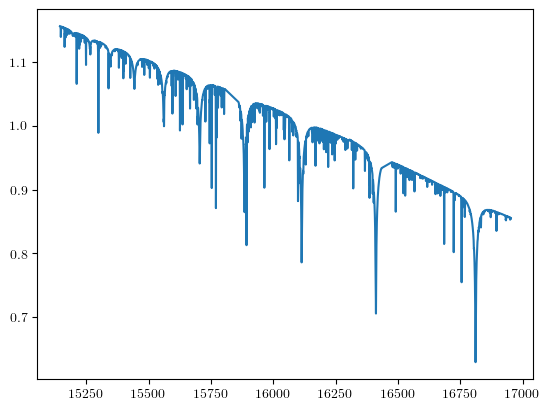

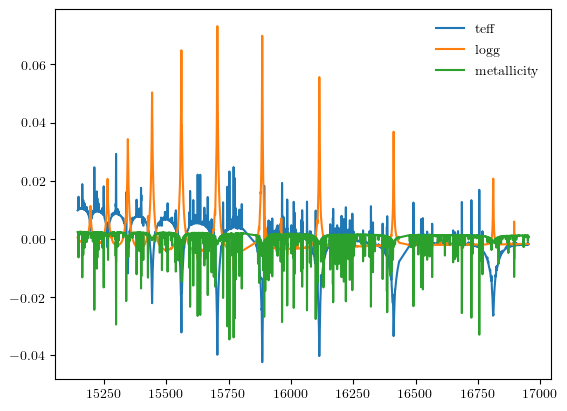

  0.004535 seconds (38.77 k allocations: 666.453 KiB)
  0.013828 seconds (115.79 k allocations: 3.246 MiB)


In [14]:
x = reverse([-1.12, 2.225, 5571.3])
plot(wls, @time interpolate_spectrum(x))

figure()
lines = plot(wls, (@time interpolated_jacobi(x)).* steps')
legend(lines, param_names)
;

# multi-interpolation with a custom type

In [6]:
struct NVec{F, N}
    data :: Vector{F}
end

In [7]:
Base.:+(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .+ y.data)
Base.:-(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .- y.data)

Base.:*(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .* y.data)
Base.:*(x::Real, y::NVec{F, N}) where F where N = NVec{F, N}(x .* y.data)
Base.:*(x::NVec{F, N}, y::Real) where F where N = NVec{F, N}(x.data .* y)

Base.:/(x::NVec{F, N}, y::Real) where F where N = NVec{F, N}(x.data ./ y)

Base.zero(::Type{NVec{F, N}}) where F where N = NVec{F, N}(zeros(F, N))

In [8]:
param_inds = CartesianIndices(size(grid)[2:end])
g = [NVec{Float32, size(grid, 1)}(grid[ :, ii]) for ii in param_inds];
itp = CubicSplineInterpolation(tuple(ranges...), g);

11×10×15 extrapolate(scale(interpolate(OffsetArray(::Array{NVec{Float32,7753},3}, 0:12, 0:11, 0:16), BSpline(Cubic(Line(OnGrid())))), (3500.0:250.0:6000.0, 0.0:0.5:4.5, -2.5:0.25:1.0)), Throw()) with element type NVec{Float32,7753}:
[:, :, 1] =
 NVec{Float32,7753}(Float32[1.00503, 1.00594, 1.00622, 1.00619, 1.00601, 1.00583, 1.00587, 1.00622, 1.00653, 1.00613  …  0.949422, 0.949371, 0.948735, 0.947647, 0.946519, 0.945741, 0.945365, 0.945235, 0.94533, 0.945781])   …  NVec{Float32,7753}(Float32[1.19262, 1.19317, 1.19333, 1.19324, 1.19297, 1.19265, 1.19256, 1.19285, 1.19329, 1.19337  …  0.838157, 0.838015, 0.837589, 0.836967, 0.836449, 0.836274, 0.836366, 0.836466, 0.836472, 0.836505])
 NVec{Float32,7753}(Float32[1.0375, 1.03754, 1.03757, 1.03759, 1.03762, 1.03764, 1.03764, 1.03758, 1.03746, 1.03725  …  0.912451, 0.912648, 0.912775, 0.912832, 0.912799, 0.912648, 0.912376, 0.912028, 0.911708, 0.911525])      NVec{Float32,7753}(Float32[1.16206, 1.16243, 1.16255, 1.1625, 1.1623, 1.16205, 1.1

In [80]:
@time interpolated_jacobi(x);
@time Interpolations.gradient(itp, x...)
;

  0.011755 seconds (115.79 k allocations: 3.246 MiB)
  0.011010 seconds (1.40 k allocations: 28.294 MiB)


It's slower :(  Perhaps if I could figure out how to tell the compiler that the grid is static get it all into one memory block...

# multi-interpolation with StaticArrays

In [ ]:
using StaticArrays
g = [SVector{size(grid, 1), Float32}(grid[ :, ii]) for ii in param_inds];
itp = CubicSplineInterpolation(tuple(ranges...), g)

# inference

In [14]:
f = interpolate_spectrum([5112.23, 3.34, 0.112])
err = ones(size(f)) * 0.01
f .+= randn(size(f)) .* err

χ2(params) = sum(((interpolate_spectrum(params) .- f) ./ err).^2)
@time res = optimize(χ2, llimits, ulimits - steps, [4000., 3., 0.])
println(res.minimizer)
res

 19.046865 seconds (175.17 M allocations: 3.134 GiB, 2.71% gc time)
[5110.953306089417, 3.347835596973603, 0.11042196929090553]


 * Status: success

 * Candidate solution
    Final objective value:     7.720430e+03

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 3.44e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.73e-14 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    6
    f(x) calls:    645
    ∇f(x) calls:   645
